In [48]:
# importing of required packages
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

lemma = WordNetLemmatizer()

In [49]:
df=pd.read_csv(r'data/training_data.csv')
df['Category']=df['label'].replace({0:'TA',1:'Malware',2:'tool'})

In [50]:
print(df.shape)
df.head()

(253, 4)


,Name,Description,label,Category
0,admin@338,G0018 admin@338 is a China-based cyber threat ...,0,TA
1,apt1,G0006 APT1 is a Chinese threat group that has ...,0,TA
2,apt12,G0005 APT12 is a threat group that has been at...,0,TA
3,apt16,G0023 APT16 is a China-based threat group that...,0,TA
4,apt17,G0025 APT17 is a China-based threat group that...,0,TA


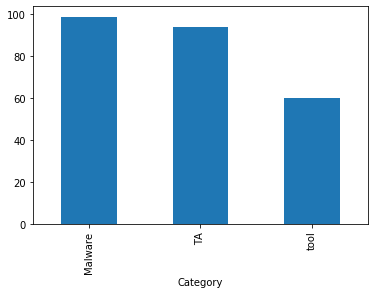

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Category').Description.count().plot.bar(ylim=0)
plt.show()

In [43]:
#function to preprocess th data
def text_preprocessing(df):
    stop_words = stopwords.words("english")+list(punctuation) # segregation stopwords and punctuations
    tokens=[]
    for index,row in df.iterrows():
        text = row['Description']
        words = [w for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w.lower() for w in words if len(w)>1] #removing if length is less than 1
        words = [lemma.lemmatize(w,'v') for w in words ] # applying lemmatization
        df['Description'][index] = ' '.join(words)
        tokens.extend(words)
        
    term_frequency = Counter(tokens)
    return df,term_frequency

In [44]:
df,tf=text_preprocessing(df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [52]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], random_state = 0)
count_vect = CountVectorizer(min_df=5,encoding='latin-1', ngram_range=(1,2), stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [53]:
len(count_vect.vocabulary_)

1396

In [54]:
print(clf.predict(count_vect.transform(["China-based cyber threat group. It has previously used newsworthy events as lures to deliver malware and has primarily targeted organizations involved in financial, economic, and trade policy, typically using publicly"])))

['Malware']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


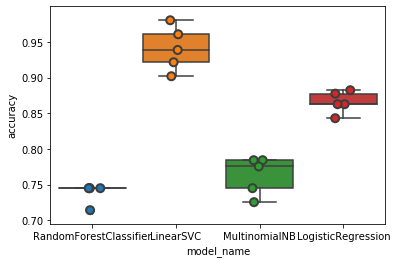

                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.745098
1   RandomForestClassifier         1  0.745098
2   RandomForestClassifier         2  0.745098
3   RandomForestClassifier         3  0.745098
4   RandomForestClassifier         4  0.714286
5                LinearSVC         0  0.960784
6                LinearSVC         1  0.921569
7                LinearSVC         2  0.901961
8                LinearSVC         3  0.980392
9                LinearSVC         4  0.938776
10           MultinomialNB         0  0.745098
11           MultinomialNB         1  0.784314
12           MultinomialNB         2  0.725490
13           MultinomialNB         3  0.784314
14           MultinomialNB         4  0.775510
15      LogisticRegression         0  0.843137
16      LogisticRegression         1  0.882353
17      LogisticRegression         2  0.862745
18      LogisticRegression         3  0.862745
19      LogisticRegression         4  0.877551


model_name
LinearSVC                 0.940696
LogisticRegression        0.865706
MultinomialNB             0.762945
RandomForestClassifier    0.738936
Name: accuracy, dtype: float64

In [56]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

X=df['Description']
Y=df['Category']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()
print(cv_df)
cv_df.groupby('model_name').accuracy.mean()

In [58]:
from io import StringIO
col = ['Category', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Category', 'Description']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Description,category_id
0,TA,G0018 admin@338 is a China-based cyber threat ...,0
1,TA,G0006 APT1 is a Chinese threat group that has ...,0
2,TA,G0005 APT12 is a threat group that has been at...,0
3,TA,G0023 APT16 is a China-based threat group that...,0
4,TA,G0025 APT17 is a China-based threat group that...,0


0.9642857142857143


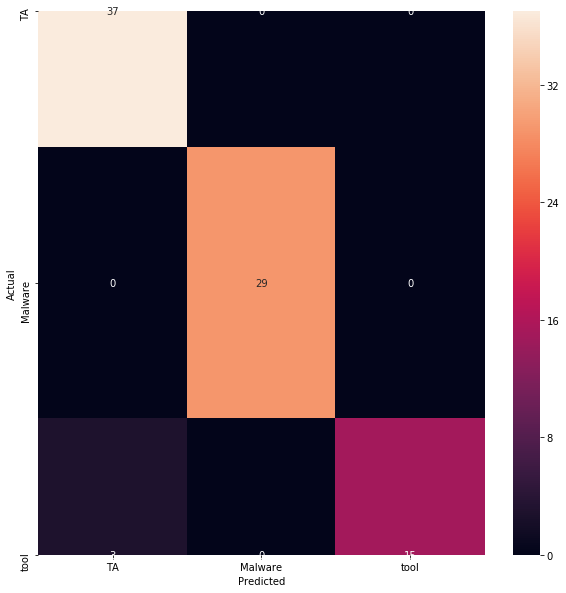

In [73]:
model = LinearSVC ()
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], test_size=0.33, random_state=0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts =  count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

model = model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
print(acc)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [74]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

          TA       0.93      1.00      0.96        37
     Malware       1.00      1.00      1.00        29
        tool       1.00      0.83      0.91        18

    accuracy                           0.96        84
   macro avg       0.97      0.94      0.96        84
weighted avg       0.97      0.96      0.96        84



In [104]:
df=pd.read_csv('data/training_data_malware_all.csv')
df_mal = df[df['label']==1]
df_mal = df_mal[100:]

In [105]:
df_mal['count_vect']=None
df_mal['tfidf_vect']=None
for index,row in df_mal.iterrows():
    test_text = [row['Description']]
    a_test = count_vect.transform(test_text)
    test = tfidf_transformer.transform(a_test)
    result_count=list(model.predict(a_test))[0]
    result_tfidf=list(model.predict(test))[0]
    df_mal['count_vect'][index] = result_count
    df_mal['tfidf_vect'][index] = result_tfidf

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [106]:
df_mal.to_csv('data/result_predictions.csv',index=False)

In [109]:
keywords_ta = pd.read_csv('data/threat_actor_keywords.csv')

In [111]:
import recordlinkage

In [112]:
keywords_ta.head()

,Name,keywords,weights,label
0,admin@338,338,0.401,0
1,admin@338,following,0.362,0
2,admin@338,temp,0.338,0
3,admin@338,lowball,0.291,0
4,admin@338,admin,0.251,0


In [117]:
import nltk
from string import punctuation
from nltk.corpus import stopwords
stop_words = stopwords.words("english")+list(punctuation)

In [127]:
text=['the Sofacy Group (also known as APT28, Pawn Storm, Fancy Bear and Sednit) is a cyber espionage group believed to have ties to the Russian government. Likely operating since 2007, the group is known to target government, military, and security organizations. It has been characterized as an advanced persistent threat.']

In [128]:
words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
words = [w for w in words if len(w)>1] #removing if length is less than 1
tokens = [lemma.lemmatize(w,'v') for w in words ] # applying lemmatization


In [137]:
df1=pd.DataFrame(tokens,columns=['keywords'])

In [133]:
df =pd.read_csv('data/threat_actor_keywords.csv',index_col='keywords')
df1.set_index('keywords',inplace=True)

In [139]:
df1.to_csv('data/test_sample_cleaned.csv')